In [1]:
import os
import glob
from dataclasses import dataclass
from collections import Counter

import pandas as pd
from tqdm.auto import tqdm


In [2]:
# ===================== 설정(Config) =====================

@dataclass
class Config:
    # parquet 파일들이 있는 폴더 / 패턴
    PARQUET_DIR: str = "/data/aiffel/data/Tahoe-100M/data"
    FILE_GLOB: str = "train-*.parquet"

    # parquet 컬럼 이름 (너 데이터에 맞게 수정!)
    COL_DRUG: str = "drug"
    COL_CELL_LINE: str = "cell_line_id"

    # 결과 저장 폴더
    OUT_DIR: str = "aiffel/babayakga/making_data"
    OUT_PREFIX: str = "tahoe_counts"

cfg = Config()


In [3]:
# ===================== parquet 파일 리스트 수집 =====================

files = sorted(glob.glob(os.path.join(cfg.PARQUET_DIR, cfg.FILE_GLOB)))
print("parquet files:", len(files))
print("first file:", files[0] if files else None)


parquet files: 3388
first file: /data/aiffel/data/Tahoe-100M/data/train-00000-of-03388.parquet


In [4]:
# ===================== 컬럼 확인 (샘플 1개 파일) =====================

sample_df = pd.read_parquet(files[0], columns=None)
print("columns:", list(sample_df.columns)[:50])
print("has drug?", cfg.COL_DRUG in sample_df.columns)
print("has cell_line?", cfg.COL_CELL_LINE in sample_df.columns)


columns: ['genes', 'expressions', 'drug', 'sample', 'BARCODE_SUB_LIB_ID', 'cell_line_id', 'moa-fine', 'canonical_smiles', 'pubchem_cid', 'plate']
has drug? True
has cell_line? True


In [5]:
# ===================== 카운터 준비 =====================

drug_counter = Counter()
cell_counter = Counter()
pair_counter = Counter()

def _safe_value(x):
    # 결측/None을 문자열 'UNKNOWN'으로 정리
    if x is None:
        return "UNKNOWN"
    try:
        if pd.isna(x):
            return "UNKNOWN"
    except Exception:
        pass
    return str(x)


In [6]:
# ===================== 전체 스캔: drug / cell_line만 읽어서 count =====================

for f in tqdm(files, desc="Scan parquet (drug/cell)", dynamic_ncols=True):
    try:
        df = pd.read_parquet(f, columns=[cfg.COL_DRUG, cfg.COL_CELL_LINE])
    except Exception as e:
        print(f"[WARN] 읽기 실패: {f} | {e}")
        continue

    drugs = df[cfg.COL_DRUG].tolist()
    cells = df[cfg.COL_CELL_LINE].tolist()

    for d, c in zip(drugs, cells):
        d = _safe_value(d)
        c = _safe_value(c)

        drug_counter[d] += 1
        cell_counter[c] += 1
        pair_counter[(d, c)] += 1

print("done.")
print("unique drugs:", len(drug_counter))
print("unique cell_lines:", len(cell_counter))
print("unique (drug, cell_line):", len(pair_counter))


Scan parquet (drug/cell):   0%|          | 0/3388 [00:00<?, ?it/s]

done.
unique drugs: 380
unique cell_lines: 50
unique (drug, cell_line): 19000


In [7]:
# ===================== Counter -> DataFrame =====================

drug_df = pd.DataFrame(
    [{"drug": k, "n_cells": v} for k, v in drug_counter.items()]
).sort_values("n_cells", ascending=False).reset_index(drop=True)

cell_df = pd.DataFrame(
    [{"cell_line_id": k, "n_cells": v} for k, v in cell_counter.items()]
).sort_values("n_cells", ascending=False).reset_index(drop=True)

pair_df = pd.DataFrame(
    [{"drug": k[0], "cell_line_id": k[1], "n_cells": v} for k, v in pair_counter.items()]
).sort_values("n_cells", ascending=False).reset_index(drop=True)

display(drug_df.head(20))
display(cell_df.head(20))
display(pair_df.head(20))


,drug,n_cells
0,DMSO_TF,2205786
1,Adagrasib,1433284
2,Afatinib,696323
3,Almonertinib (mesylate),592031
4,Cytarabine,551715
5,Fumaric acid,549353
6,Binimetinib,548375
7,Belumosudil,527152
8,Pravastatin (sodium),525712
9,Berbamine (dihydrochloride),517166


,cell_line_id,n_cells
0,CVCL_0546,6040371
1,CVCL_0459,5736238
2,CVCL_0480,4089586
3,CVCL_1285,3307302
4,CVCL_0399,3013246
5,CVCL_1056,2737714
6,CVCL_0023,2567838
7,CVCL_0334,2535736
8,CVCL_0293,2514625
9,CVCL_0428,2432647


,drug,cell_line_id,n_cells
0,DMSO_TF,CVCL_0546,139224
1,DMSO_TF,CVCL_0459,126345
2,DMSO_TF,CVCL_0480,95259
3,Adagrasib,CVCL_0546,93235
4,Adagrasib,CVCL_0459,85279
5,DMSO_TF,CVCL_1285,75431
6,DMSO_TF,CVCL_0399,67833
7,DMSO_TF,CVCL_1056,64417
8,Adagrasib,CVCL_0480,63439
9,DMSO_TF,CVCL_0023,60135


In [8]:
# ===================== 결과 저장 =====================

os.makedirs(cfg.OUT_DIR, exist_ok=True)

drug_path = os.path.join(cfg.OUT_DIR, f"{cfg.OUT_PREFIX}_per_drug.csv")
cell_path = os.path.join(cfg.OUT_DIR, f"{cfg.OUT_PREFIX}_per_cell_line.csv")
pair_path = os.path.join(cfg.OUT_DIR, f"{cfg.OUT_PREFIX}_per_drug_cell_line.csv")

drug_df.to_csv(drug_path, index=False)
cell_df.to_csv(cell_path, index=False)
pair_df.to_csv(pair_path, index=False)

print("saved:")
print(" -", drug_path)
print(" -", cell_path)
print(" -", pair_path)


saved:
 - aiffel/babayakga/making_data/tahoe_counts_per_drug.csv
 - aiffel/babayakga/making_data/tahoe_counts_per_cell_line.csv
 - aiffel/babayakga/making_data/tahoe_counts_per_drug_cell_line.csv


In [9]:
print("drug stats:", drug_df["n_cells"].describe(percentiles=[0.5, 0.9, 0.95, 0.99]))
print("cell stats:", cell_df["n_cells"].describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

drug stats: count    3.800000e+02
mean     2.516430e+05
std      1.460072e+05
min      4.569200e+04
50%      2.347495e+05
90%      3.345579e+05
95%      4.190151e+05
99%      5.601814e+05
max      2.205786e+06
Name: n_cells, dtype: float64
cell stats: count    5.000000e+01
mean     1.912487e+06
std      1.172922e+06
min      1.834000e+04
50%      1.833414e+06
90%      2.765267e+06
95%      3.737558e+06
99%      5.891346e+06
max      6.040371e+06
Name: n_cells, dtype: float64


In [10]:
# ✅ (drug, cell_line) 조합 빈도표
df_pair = pd.DataFrame(
    [(d, c, n) for (d, c), n in pair_counter.items()],
    columns=["drug", "cell_line_id", "n_cells"]
).sort_values("n_cells", ascending=False).reset_index(drop=True)

display(df_pair.head(30))
print("pair stats:", df_pair["n_cells"].describe(percentiles=[0.5, 0.9, 0.95, 0.99]))


,drug,cell_line_id,n_cells
0,DMSO_TF,CVCL_0546,139224
1,DMSO_TF,CVCL_0459,126345
2,DMSO_TF,CVCL_0480,95259
3,Adagrasib,CVCL_0546,93235
4,Adagrasib,CVCL_0459,85279
5,DMSO_TF,CVCL_1285,75431
6,DMSO_TF,CVCL_0399,67833
7,DMSO_TF,CVCL_1056,64417
8,Adagrasib,CVCL_0480,63439
9,DMSO_TF,CVCL_0023,60135


pair stats: count     19000.000000
mean       5032.859684
std        4718.107167
min          10.000000
50%        4257.500000
90%        9288.200000
95%       12144.200000
99%       20298.900000
max      139224.000000
Name: n_cells, dtype: float64


In [17]:
# ✅ 기준을 바꿔가며 얼마나 많은 drug가 필터링되는지 확인
thresholds = [10000, 50000, 100000, 500000]

for t in thresholds:
    n_ok = (drug_df["n_cells"] >= t).sum()
    print(f"min_cells_per_drug >= {t:>4}: {n_ok:>6} / {len(drug_df)} drugs")


min_cells_per_drug >= 10000:    380 / 380 drugs
min_cells_per_drug >= 50000:    379 / 380 drugs
min_cells_per_drug >= 100000:    374 / 380 drugs
min_cells_per_drug >= 500000:     11 / 380 drugs


In [32]:
# ✅ pair 단위로 최소 샘플 수 확인
pair_thresholds = [200, 500, 1000, 10000]

for t in pair_thresholds:
    n_ok = (df_pair["n_cells"] >= t).sum()
    print(f"min_cells_per_pair >= {t:>3}: {n_ok:>8} / {len(df_pair)} pairs")


min_cells_per_pair >= 200:    18089 / 19000 pairs
min_cells_per_pair >= 500:    17398 / 19000 pairs
min_cells_per_pair >= 1000:    16846 / 19000 pairs
min_cells_per_pair >= 10000:     1579 / 19000 pairs


In [18]:
TOPK = 30

print("=== TOP drugs ===")
display(drug_df.head(TOPK))

print("=== TOP cell lines ===")
display(cell_df.head(TOPK))

print("=== TOP (drug, cell_line) pairs ===")
display(df_pair.head(TOPK))


=== TOP drugs ===


,drug,n_cells
0,DMSO_TF,2205786
1,Adagrasib,1433284
2,Afatinib,696323
3,Almonertinib (mesylate),592031
4,Cytarabine,551715
5,Fumaric acid,549353
6,Binimetinib,548375
7,Belumosudil,527152
8,Pravastatin (sodium),525712
9,Berbamine (dihydrochloride),517166


=== TOP cell lines ===


,cell_line_id,n_cells
0,CVCL_0546,6040371
1,CVCL_0459,5736238
2,CVCL_0480,4089586
3,CVCL_1285,3307302
4,CVCL_0399,3013246
5,CVCL_1056,2737714
6,CVCL_0023,2567838
7,CVCL_0334,2535736
8,CVCL_0293,2514625
9,CVCL_0428,2432647


=== TOP (drug, cell_line) pairs ===


,drug,cell_line_id,n_cells
0,DMSO_TF,CVCL_0546,139224
1,DMSO_TF,CVCL_0459,126345
2,DMSO_TF,CVCL_0480,95259
3,Adagrasib,CVCL_0546,93235
4,Adagrasib,CVCL_0459,85279
5,DMSO_TF,CVCL_1285,75431
6,DMSO_TF,CVCL_0399,67833
7,DMSO_TF,CVCL_1056,64417
8,Adagrasib,CVCL_0480,63439
9,DMSO_TF,CVCL_0023,60135


In [19]:
# ✅ pivot: (drug, cell_line) -> n_cells
pivot = df_pair.pivot_table(
    index="drug",
    columns="cell_line_id",
    values="n_cells",
    aggfunc="sum",
    fill_value=0
)

print("pivot shape:", pivot.shape)
display(pivot.iloc[:20, :20])


pivot shape: (380, 50)


cell_line_id,CVCL_0023,CVCL_0028,CVCL_0069,CVCL_0099,CVCL_0131,CVCL_0152,CVCL_0179,CVCL_0218,CVCL_0292,CVCL_0293,CVCL_0320,CVCL_0332,CVCL_0334,CVCL_0359,CVCL_0366,CVCL_0371,CVCL_0397,CVCL_0399,CVCL_0428,CVCL_0459
drug,,,,,,,,,,,,,,,,,,,,
(R)-Verapamil (hydrochloride),8777,2242,4654,2676,9634,8901,4817,4637,4234,9288,6904,4874,3286,8287,5813,7252,5359,10722,3991,15422
(S)-Crizotinib,5752,1222,4634,4004,4572,4436,2941,3771,4269,4688,5020,4386,8885,5278,2722,5419,4293,6579,8749,15023
18β-Glycyrrhetinic acid,6005,1416,3236,1568,6274,5793,3061,3121,2430,6597,4799,3172,2373,5569,3646,5277,3646,7363,2955,9999
4EGI-1,5687,1470,3101,1855,5920,5871,3502,3591,3246,6640,5097,3261,2379,5097,3127,5192,4198,7563,2752,11640
5-Azacytidine,4901,1067,3028,2929,3654,3728,2227,3086,3559,4578,4483,3378,7582,4411,2304,4613,3559,5317,7041,12130
5-Fluorouracil,5896,1022,4155,3924,4798,4701,2707,3994,4103,5238,5350,4955,10184,5406,3237,5584,4778,6740,9240,16955
8-Hydroxyquinoline,8730,2463,4877,2713,9161,8526,4880,4442,4158,9069,6554,4755,3534,8287,5691,7019,5396,10072,4061,15650
9-ING-41,6228,1064,2664,1654,6676,6071,3129,3632,2662,7674,5639,3743,2215,4684,4101,5511,4813,7793,2720,12148
APTO-253,6147,1754,3447,1899,6275,6181,3437,3893,3315,7216,5427,3411,2480,5286,3985,5388,4806,8361,2544,12631


In [26]:
import numpy as np
import matplotlib.pyplot as plt


def plot_log_hist(values, title, bins=50):
    values = np.asarray(values)
    values = values[values > 0] 

    log_values = np.log10(values)

    plt.figure(figsize=(7,5))
    plt.hist(log_values, bins=bins)
    plt.xlabel("log10(#cells)")
    plt.ylabel("count")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


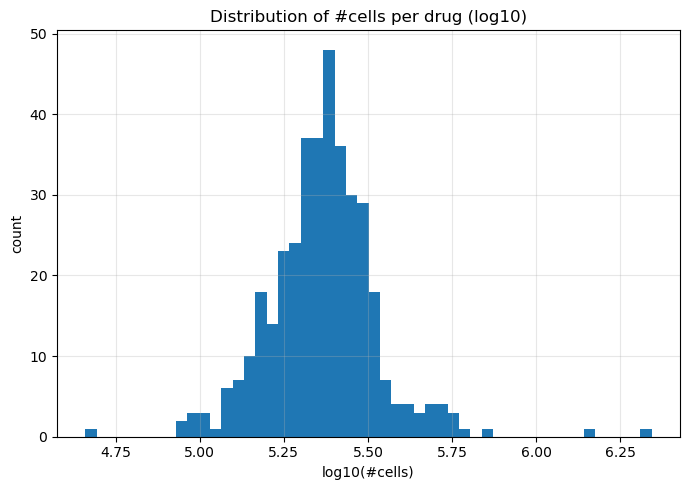

In [27]:
plot_log_hist(
    drug_df["n_cells"],
    title="Distribution of #cells per drug (log10)"
)


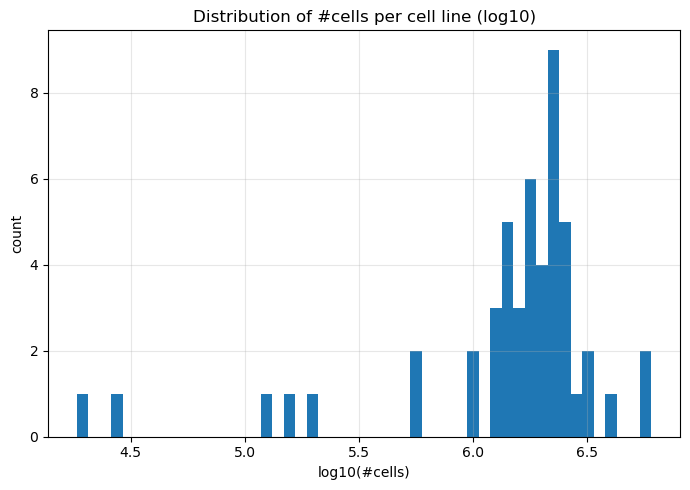

In [28]:
plot_log_hist(
    cell_df["n_cells"],
    title="Distribution of #cells per cell line (log10)"
)

In [29]:
def plot_top_bar(df, name_col, count_col, title, topn=20):
    d = df.sort_values(count_col, ascending=False).head(topn)

    plt.figure(figsize=(8,6))
    plt.barh(d[name_col].astype(str)[::-1], d[count_col][::-1])
    plt.xlabel(count_col)
    plt.ylabel(name_col)
    plt.title(title)
    plt.tight_layout()
    plt.show()


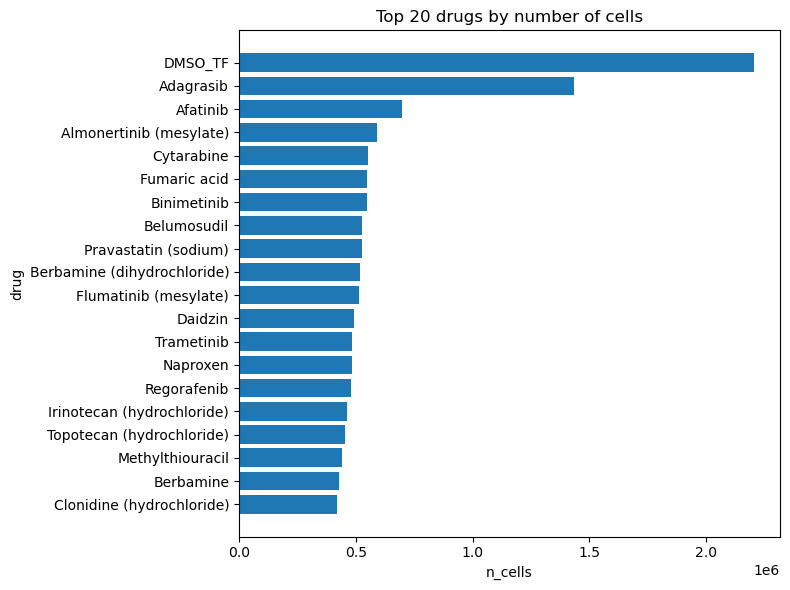

In [30]:
plot_top_bar(
    drug_df,
    name_col="drug",
    count_col="n_cells",
    title="Top 20 drugs by number of cells",
    topn=20
)


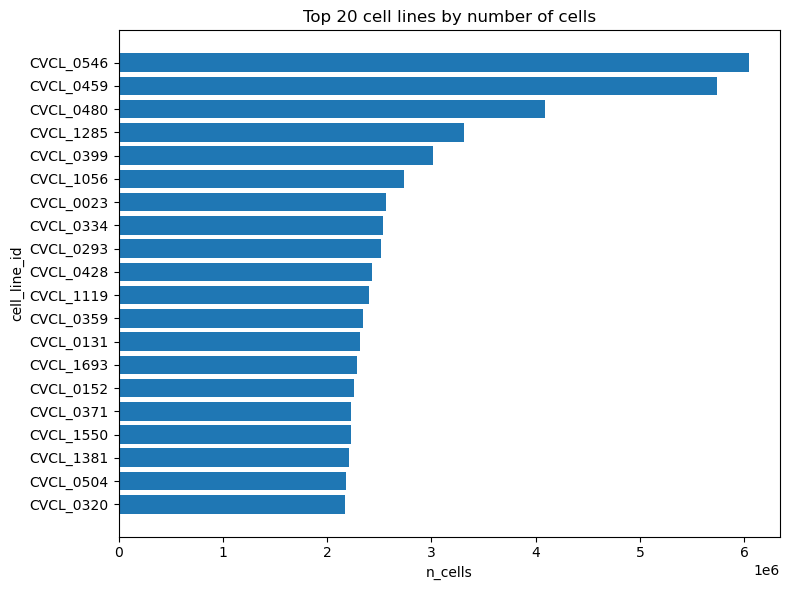

In [31]:
plot_top_bar(
    cell_df,
    name_col="cell_line_id",
    count_col="n_cells",
    title="Top 20 cell lines by number of cells",
    topn=20
)


1. 세포주 분석 (tahoe_counts_per_cell_line.csv)
세포주 간 세포 수의 심각한 불균형(Imbalance)이 관찰됩니다:
상위 그룹: 상위 3개 세포주는 나머지 세포주에 비해 압도적으로 많은 세포 수를 포함하고 있습니다.
CVCL_0546: 약 604만 개
CVCL_0459: 약 574만 개
CVCL_0480: 약 409만 개
하위 그룹: 리스트의 끝부분에는 데이터 커버리지가 매우 낮은 세포주들이 존재합니다.
CVCL_1531: 약 2.8만 개
CVCL_1571: 약 1.8만 개
결론: 가장 많은 데이터를 가진 세포주와 가장 적은 세포주 간의 차이는 300배 이상입니다. 머신러닝(ML) 모델 학습 시, 이대로 사용하면 CVCL_0546에 대한 예측 성능은 우수하겠지만, 하위권 세포주들에 대해서는 성능이 떨어지거나 불안정할 가능성이 높습니다.
2. 약물 분석 (tahoe_counts_per_drug.csv)
"슈퍼 클래스"와 "Long Tail(긴 꼬리)" 분포가 뚜렷합니다:
대조군 (Control): DMSO_TF(표준 용매/대조군)가 약 220만 개의 세포로 1위를 차지했습니다. 이는 다른 모든 샘플과 비교하기 위한 기준점이므로 실험 설계상 타당합니다.
지배적인 약물: Adagrasib(아다그라십)은 약 143만 개의 세포를 보유하고 있으며, 이는 다른 어떤 활성 물질보다 2~7배 많은 수치입니다.
가설: 본 연구는 아다그라십(KRAS G12C 억제제)의 효능 연구에 집중되어 있거나, 다양한 농도/조건에서 이 약물이 더 빈번하게 사용되었을 가능성이 높습니다.
주요 그룹: 대부분의 다른 약물(Afatinib, Cytarabine 등)은 20만~70만 개 수준의 분포를 보입니다.
희귀 약물: 리스트 끝에는 데이터가 적은 약물들이 있습니다 (예: Dinaciclib — 4.5만 개).
3. 약물-세포주 조합 분석 (tahoe_counts_per_drug_cell_line.csv)
이 파일은 구체적인 실험 내 세포 분포를 보여줍니다.
커버리지의 불균형:
상위 라인인 CVCL_0546의 경우 대조군(DMSO)에 약 14만 개의 세포가 할당되어 있습니다.
반면 하위 라인(CVCL_1716 등)의 경우 동일한 DMSO 조건이라도 데이터가 매우 부족한 것으로 보입니다.
최소값: 파일의 끝부분에는 세포 수가 극도로 적은 조합들이 확인됩니다 (예: CVCL_1571에 처리된 vincristine — 단 10개의 세포).
결론: 세포 수가 50~100개 미만인 조합에 대한 통계적 분석은 신뢰하기 어렵습니다. scRNA-seq 데이터 특유의 기술적 노이즈가 생물학적 신호를 덮어버릴 수 있습니다.

In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('/data/aiffel/babayakga/making_data/cell_line_metadata.csv')

In [5]:
df.columns

Index(['cell_name', 'Cell_ID_DepMap', 'Cell_ID_Cellosaur', 'Organ',
       'Driver_Gene_Symbol', 'Driver_VarZyg', 'Driver_VarType',
       'Driver_ProtEffect_or_CdnaEffect', 'Driver_Mech_InferDM',
       'Driver_GeneType_DM'],
      dtype='object')

In [6]:
df['Organ'].value_counts()

Organ
Bowel                        426
Lung                         200
Esophagus/Stomach             63
Pancreas                      55
Skin                          54
Uterus                        54
Breast                        49
Ovary/Fallopian Tube          24
Cervix                        21
CNS/Brain                     18
Liver                         14
Bladder/Urinary Tract          9
Vulva/Vagina                   6
Kidney                         6
Peripheral Nervous System      1
Name: count, dtype: int64